In [9]:
from scipy.io import loadmat
import numpy as np

In [10]:
def calc_fairness_metric(constraint, confu_mat, num_groups=2, num_classes=2):
    if constraint == 'eopp':
        '''
        Compute EO disparity
        '''
        group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
        group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()

        pivot = (group0_tp + group1_tp) / (group0_fn + group0_tp + group1_fn + group1_tp)
        group0_tpr = group0_tp / (group0_fn + group0_tp)
        group1_tpr = group1_tp / (group1_fn + group1_tp)

        return max(abs(group0_tpr - pivot), abs(group1_tpr - pivot)) # from fairbatch paper
        #return abs(group0_tp / (group0_fn + group0_tp) - group1_tp / (group1_fn + group1_tp))

    elif constraint == 'eo':
        '''
        Compute ED disparity 
        '''

        group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
        group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()
        
        pivot_1 = (group0_tp + group1_tp) / (group0_fn + group0_tp + group1_fn + group1_tp)
        group0_tpr = group0_tp / (group0_fn + group0_tp)
        group1_tpr = group1_tp / (group1_fn + group1_tp)

        EO_Y_1 = max(abs(group0_tpr - pivot_1), abs(group1_tpr - pivot_1))

        pivot_0 = (group0_fp + group1_fp) / (group0_tn + group0_fp + group1_tn + group1_fp)
        group0_fpr = (group0_fp) / (group0_tn + group0_fp)
        group1_fpr = (group1_fp) / (group1_tn + group1_fp)

        EO_Y_0 = max(abs(group0_fpr - pivot_0), abs(group1_fpr - pivot_0))

        return max(EO_Y_0, EO_Y_1)

    elif constraint == 'dp':
        pass

def calc_acc(constraint, confu_mat, num_classes=2, num_groups=2):
    group0_tn, group0_fp, group0_fn, group0_tp = confu_mat['0'].ravel()
    group1_tn, group1_fp, group1_fn, group1_tp = confu_mat['1'].ravel()
    
    return (group0_tn + group0_tp + group1_tn + group1_tp) / (confu_mat['0'].ravel().sum() + confu_mat['1'].ravel().sum())


In [11]:

method = "adv_debiasing"
dataset = "adult"
sen_attr_dict = {
    "adult": "sex",
    "compas": "sex",
    "retiring_adult": "race",
    "retiring_adult": "race"
}

sen_attr = sen_attr_dict[dataset]
constraint = "eo"


In [12]:

filename_epi = "mlp_{}_seed{}_epochs50_bs128_lr{:.4f}_decay{:.4f}"
seed_arr = [0, 1, 2]
date = "20220214"

if method == "reweighting":
    pass
elif method == "adv_debiasing":
    filename = filename_epi + "_adv_lamb{}_eta{}_constraint{}_test_confu"
    lr = 0.0005
    decay = 0.0005
#     lamb_arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lamb_arr = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 20.0, 30.0, 50.0, 100.0]
#     eta_arr = [0.001, 0.003, 0.005, 0.007, 0.01]
    eta_arr = [0.001, 0.003, 0.005, 0.01]
    


In [13]:

results_fair = np.zeros((len(seed_arr), len(eta_arr), len(lamb_arr)))
results_acc = np.zeros((len(seed_arr), len(eta_arr), len(lamb_arr)))

for seed in seed_arr:
    for i, eta in enumerate(eta_arr):
        for j, lamb in enumerate(lamb_arr):
            confu_mat = loadmat("./results/{}/{}/{}/{}".format(date, dataset, method, filename.format(sen_attr, seed, lr, decay, lamb, eta, constraint)), appendmat=False)
#             print(calc_fairness_metric(constraint, confu_mat))
            results_fair[seed, i, j] += calc_fairness_metric(constraint, confu_mat)
            results_acc[seed, i, j] += calc_acc(constraint, confu_mat)

results_fair = np.mean(results_fair, axis=0)
results_acc = np.mean(results_acc, axis=0)


print(results_fair, results_acc)


[[0.04735459 0.0474403  0.04736771 0.04478351 0.03840523 0.07828629
  0.13010825 0.12605614 0.15493432 0.15425315 0.12078113 0.18673295
  0.13334947]
 [0.04692313 0.04756292 0.04633748 0.04467401 0.03839868 0.0631434
  0.14247899 0.09014563 0.14382939 0.20999088 0.22461673 0.07916525
  0.12614363]
 [0.04784919 0.04760517 0.04675826 0.04408958 0.03838022 0.07563741
  0.11846954 0.07724929 0.17246454 0.09865095 0.09877722 0.09659495
  0.08706659]
 [0.04769088 0.04760517 0.04664876 0.04395506 0.03762436 0.06565408
  0.11095396 0.09079331 0.08579459 0.09932591 0.10949866 0.11711025
  0.11072179]] [[0.85140962 0.8518887  0.85122535 0.85115165 0.84956698 0.84779805
  0.83814262 0.81138751 0.70005528 0.73060623 0.69323752 0.71464898
  0.69449051]
 [0.85059886 0.85155703 0.85133591 0.85081997 0.84938272 0.84849825
  0.83887968 0.8212272  0.7634052  0.72139303 0.6976967  0.6444813
  0.58570112]
 [0.85085683 0.85174129 0.85034089 0.85067256 0.85026718 0.84742952
  0.84179104 0.81787359 0.7602358

In [14]:

argmin = np.unravel_index(results_fair.argmin(), results_fair.shape)
print(argmin)
print(results_fair[argmin], results_acc[argmin])


(3, 4)
0.037624364302983805 0.8498249493274369


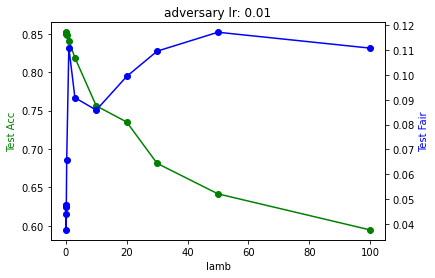

In [15]:

import matplotlib.pyplot as plt

x = lamb_arr
y1 = results_acc[argmin[0], :]
y2 = results_fair[argmin[0], :]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'go-')
ax2.plot(x, y2, 'bo-')

ax1.set_xlabel('lamb')
ax1.set_ylabel('Test Acc', color='g')
ax2.set_ylabel('Test Fair', color='b')

plt.title(f"adversary lr: {eta_arr[argmin[0]]}")

plt.show()


